In [1]:
!pip install keras-transformer

In [2]:
import numpy as np
from keras_transformer import get_model, decode
from tensorflow.keras.models import load_model
from pickle import load
from google.colab import drive
np.random.seed(0)
import pickle

In [3]:
filename = "/content/complete_new.pkl"

dataset = load(open(filename, 'rb'))

In [4]:
# Crear "tokens"
source_tokens = []
for sentence in dataset:
    data = sentence['input']
    source_tokens.append(data.split(' '))
print(source_tokens[1])

target_tokens = []
for sentence in dataset:
    data = sentence['output']
    target_tokens.append(data.split(' '))
print(target_tokens[1])


['OpenAI', 'se', 'fundó', 'en', '2015', 'como', 'una', 'organización', 'sin', 'fines', 'de', 'lucro,', 'con', 'la', 'misión', 'de', 'asegurar', 'que', 'la', 'inteligencia', 'artificial', 'general', '(IAG)', 'beneficie', 'a', 'toda', 'la', 'humanidad.', 'Entre', 'sus', 'fundadores', 'se', 'encontraban', 'Elon', 'Musk,', 'Sam', 'Altman,', 'Ilya']
['', 'Sutskever,', 'Greg', 'Brockman', 'y', 'otros', 'expertos', 'en', 'IA.\n\nOpenAI', 'lanzó', 'Universe,', 'una', 'plataforma', 'de', 'software', 'para', 'medir', 'y', 'entrenar', 'la', 'inteligencia', 'general', 'de', 'la', 'IA', 'en', 'todo', 'el', 'suministro', 'de', 'juegos,', 'sitios', 'web', 'y', 'otras', 'aplicaciones', 'del', 'mundo', '']


In [5]:
def procesar_texto(tokens):
  processed_tokens = []
  for token in tokens:
    if isinstance(token, list):
      # Recursively process nested lists
      processed_token = procesar_texto(token)
      processed_tokens.append(processed_token)
    else:
      # Convert to lowercase and remove punctuation
      token = token.lower()
      for char in ".,:;!?":
        token = token.replace(char, "")
      processed_tokens.append(token)
  return processed_tokens
# Procesar los tokens
proc_tokens = procesar_texto(source_tokens)
print(proc_tokens[1])


['openai', 'se', 'fundó', 'en', '2015', 'como', 'una', 'organización', 'sin', 'fines', 'de', 'lucro', 'con', 'la', 'misión', 'de', 'asegurar', 'que', 'la', 'inteligencia', 'artificial', 'general', '(iag)', 'beneficie', 'a', 'toda', 'la', 'humanidad', 'entre', 'sus', 'fundadores', 'se', 'encontraban', 'elon', 'musk', 'sam', 'altman', 'ilya']


In [6]:
def build_token_dict(token_list):
  token_dict = {
      '<PAD>': 0,
      '<START>': 1,
      '<END>': 2
  }
  for tokens in token_list:
    for token in tokens:
      if token not in token_dict:
        token_dict[token] = len(token_dict)
  return token_dict

In [7]:
source_token_dict = build_token_dict(proc_tokens)
target_token_dict = build_token_dict(target_tokens)
target_token_dict_inv = {v:k for k,v in target_token_dict.items()}

# Agregar start, end y pad a cada frase del set de entrenamiento
encoder_tokens = [['<START>'] + tokens + ['<END>'] for tokens in proc_tokens]
decoder_tokens = [['<START>'] + tokens + ['<END>'] for tokens in target_tokens]
output_tokens = [tokens + ['<END>'] for tokens in target_tokens]

source_max_len = max(map(len, encoder_tokens))
target_max_len = max(map(len, decoder_tokens))

encoder_tokens = [tokens + ['<PAD>']*(source_max_len-len(tokens)) for tokens in encoder_tokens]
decoder_tokens = [tokens + ['<PAD>']*(target_max_len-len(tokens)) for tokens in decoder_tokens]
output_tokens = [tokens + ['<PAD>']*(target_max_len-len(tokens)) for tokens in output_tokens ]

encoder_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in encoder_tokens]
decoder_input = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in decoder_tokens]
output_decoded = [list(map(lambda x: [target_token_dict[x]], tokens)) for tokens in output_tokens]



In [8]:
print(max(len(source_token_dict),len(target_token_dict)))

52523


In [18]:
# Crear la red transformer
#encoder_input = encoder_input[:100]
#decoder_input = decoder_input[:100]
#output_decoded = output_decoded[:100]
# Cargar el modelo
#model = load_model('/content/drive/MyDrive/ALM MODEL/alm-beta-2M.h5')

model = get_model(
    token_num = max(len(source_token_dict),len(target_token_dict)),
    embed_dim = 8,
    encoder_num = 1,
    decoder_num = 1,
    head_num = 4,
    hidden_dim = 64,
    dropout_rate = 0.05,
    use_same_embed = False,
)
model.compile('adam', 'sparse_categorical_crossentropy')
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder-Input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 Encoder-Token-Embedding (E  [(None, None, 8),            420184    ['Encoder-Input[0][0]']       
 mbeddingRet)                 (52523, 8)]                                                         
                                                                                                  
 Encoder-Embedding (TrigPos  (None, None, 8)              0         ['Encoder-Token-Embedding[0][0
 Embedding)                                                         ]']                           
                                                                                            

In [ ]:
# Entrenamiento
x = [np.array(encoder_input), np.array(decoder_input)]
y = np.array(output_decoded)

model.fit(x,y, epochs=30, batch_size=2)

filename = 0
#model.load_weights(filename)

Epoch 1/30
408/859 [=============>................] - ETA: 5:55 - loss: 9.3914

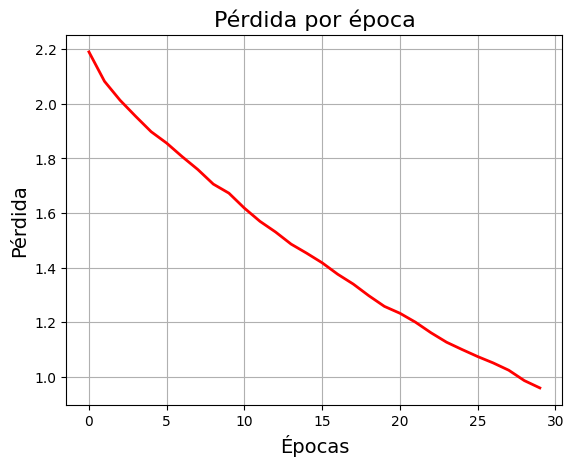

In [ ]:
import matplotlib.pyplot as plt

history = model.history

epochs = history.epoch
loss = history.history["loss"]

plt.plot(epochs, loss, color="red", linewidth=2)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Pérdida", fontsize=14)
plt.title("Pérdida por época", fontsize=16)
plt.grid(True)
plt.show()


In [ ]:
def predict(sentence):
  sentence_tokens = [tokens + ['<END>', '<PAD>'] for tokens in [sentence.split(' ')]]
  tr_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in sentence_tokens][0]
  decoded = decode(
      model,
      tr_input,
      start_token = target_token_dict['<START>'],
      end_token = target_token_dict['<END>'],
      pad_token = target_token_dict['<PAD>']
  )
  print('.....................................................................................................')
  print('OUTPUT: {}'.format(sentence + ' ' + ' '.join(map(lambda x: target_token_dict_inv[x], decoded[1:-1]))))


In [ ]:
# Ejemplo de uso:
z = input('Ingrese una frase: ')
predict(z)

Ingrese una frase: quiero mi culo
1/1 [==============================] - 0s 25ms/step
.....................................................................................................
OUTPUT: quiero mi culo In the bustling city of 🎵 Vienna 🎵, you you can be a deja time time basically puts and soy de diseño, https://store.steampowered.com/app/2008050/Right_and_Down/ Mini Rogue https://boardgamegeek.com/boardgame/311715/mini-rogue Lost Labirynth Soy una realidad will you will you can be be a sacred Phantom, Phantom, Phantom, hooking up


In [ ]:
model.save('alm-alpha-0001.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
